# Markets physics - TP 3.3 : Market gain and impact

**Hugo Yeremian - Martín Pasche**

---

## Importing and defining useful functions

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
from tqdm import tqdm
import seaborn as sns
from tqdm import tqdm

### Game running functions

In [2]:
def create_variables(seed, iterations, Ns, P, Np, init_mu_U, init_std_U):
    """
    Create variables for the game using efficient data types.
    """
    np.random.seed(seed)

    # dimensions : state using float32 for efficiency
    Omega = np.random.normal(0, Np, P).astype(np.float32)

    # dimensions : i , mu
    # Generate values only 0 and 1 and map them to -1 and 1,
    # then convert to int8 to save memory.
    a = (np.random.randint(0, 2, size=(Ns, P)) * 2 - 1).astype(np.int8)
    
    # Initialize accumulated performance using float32
    U = np.empty((Ns, iterations + 1), dtype=np.float32)
    U[:, 0] = np.random.normal(init_mu_U, init_std_U, size=Ns).astype(np.float32)
    U[:, 1:] = 0.0  # filling rest with 0
    
    # Matrix of actions over time, using float32
    A = np.zeros(iterations, dtype=np.float32)
    
    # Initial market state, using uint8 assuming P is small (change to int32 if needed)
    mu = np.random.randint(0, P, dtype=np.uint8)
    
    return a, Omega, U, A, mu


@njit
def run_game(a, mu, Omega, U, A, eps, iterations):
    P = Omega.shape[0]
    Ns = a.shape[0]
    mu = mu
    
    for t in range(iterations):
        n = np.where(U[:, t] > 0, 1, 0)
        actions = a[:, mu] * n
        A[t] = Omega[mu] + actions.sum()
        
        U[:, t+1] = U[:, t] - a[:, mu] * A[t] - eps 
        # mu = np.random.randint(0, P)
        add_val = 1 if A[t] > 0 else 0
        mu = (2 * mu + add_val) % P
    return A, U

@njit
def run_game_with_mu(a, Omega, U, A, eps, mu, iterations):
    P = Omega.shape[0]
    Ns = a.shape[0]
    mu_hist = np.empty(iterations, dtype=np.int32)
    
    for t in range(iterations):
        mu_hist[t] = mu
        n = (U[:, t] > 0).astype(np.int32)
        actions = a[:, mu] * n
        A[t] = Omega[mu] + actions.sum()
        U[:, t+1] = U[:, t] - a[:, mu] * A[t] - eps
        mu = (2 * mu + (1 if A[t] > 0 else 0)) % P
    
    return A, mu_hist



@njit
def run_game_gains(a, Omega, U, A, eps, mu, iterations):
    P = Omega.shape[0]
    Ns = a.shape[0]
    mu_hist = np.empty(iterations, dtype=np.int32)
    G_prod = np.zeros(iterations)
    G_spec = np.zeros(iterations)

    for t in range(iterations):
        mu_hist[t] = mu
        n = (U[:, t] > 0).astype(np.int32)
        actions = a[:, mu] * n
        A_spec = actions.sum()
        A[t] = Omega[mu] + A_spec

        # Update gains
        G_prod[t] = -Omega[mu] * A[t]
        G_spec[t] = -A_spec * A[t]

        U[:, t+1] = U[:, t] - a[:, mu] * A[t] - eps
        mu = (2 * mu + (1 if A[t] > 0 else 0)) % P
        #mu = np.random.randint(0, P)
    return A, U, mu_hist, G_prod, G_spec

def compute_average_gains(G_prod, G_spec, burnin=0):
    return np.mean(G_prod[burnin:]), np.mean(G_spec[burnin:])


def compute_phi(U, burnin=0):
    # Solo usar datos luego del estado estacionario
    U_stationary = U[:, burnin:]
    phi = (U_stationary > 0).mean(axis=1)
    return phi


def compute_individual_gains(a, A, mu_hist, U, burnin=0):
    Ns, P = a.shape
    T = len(A)

    # Slice time after burnin
    A_burn = A[burnin:]
    mu_burn = mu_hist[burnin:]
    U_burn = U[:, burnin:T]  # <<< fixed here

    # Participation mask: shape (Ns, T-burnin)
    active_mask = U_burn > 0

    # Gather a[i, mu_t] into shape (Ns, T-burnin)
    a_mu = a[:, mu_burn]  # shape (Ns, T-burnin)

    # Compute payoff at each t: -a[i, mu_t] * A[t]
    A_broadcasted = A_burn[np.newaxis, :]  # shape (1, T-burnin)
    gains_matrix = -a_mu * A_broadcasted

    # Zero out gains where agent was not active
    gains_matrix *= active_mask

    # Sum and count only active steps
    gain_sum = gains_matrix.sum(axis=1)
    active_counts = active_mask.sum(axis=1)

    # Avoid division by zero
    gains = np.where(active_counts > 0, gain_sum / active_counts, 0)

    return gains



@njit
def run_game_partial_impact_matrix(a, Omega, U, A, eps, mu, iterations, kappa_matrix):
    P = Omega.shape[0]
    Ns = a.shape[0]
    mu_hist = np.empty(iterations, dtype=np.int32)
    active_count = np.zeros(Ns, dtype=np.int32)
    gains = np.zeros(Ns)

    for t in range(iterations):
        mu_hist[t] = mu
        n = (U[:, t] > 0).astype(np.int32)
        actions = a[:, mu] * n
        A[t] = Omega[mu] + actions.sum()

        for i in range(Ns):
            penalty = kappa_matrix[i, t] * (1 - n[i])
            U[i, t+1] = U[i, t] - a[i, mu] * A[t] - eps - penalty

            if n[i] == 1:
                active_count[i] += 1
                gains[i] += -a[i, mu] * A[t]

        mu = (2 * mu + (1 if A[t] > 0 else 0)) % P

    phi = active_count / iterations
    avg_gain = gains / np.maximum(active_count, 1)

    return A, mu_hist, phi, avg_gain, kappa_matrix


def generate_kappa_matrix(Ns, iterations, rho=0.5, kappa_value=0.2, seed=0):
    np.random.seed(seed)
    kappa_matrix = np.zeros((Ns, iterations), dtype=np.float32)
    conscious_agents = np.random.choice(Ns, int(rho * Ns), replace=False)
    for i in conscious_agents:
        kappa_matrix[i, :] = kappa_value
    return kappa_matrix, conscious_agents

## 1 - Frequence of game and impact

Choose the parameters so that in the stationary regime there arent big fluctuations. 

We can measure fluctuations with $<A^2>$

100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


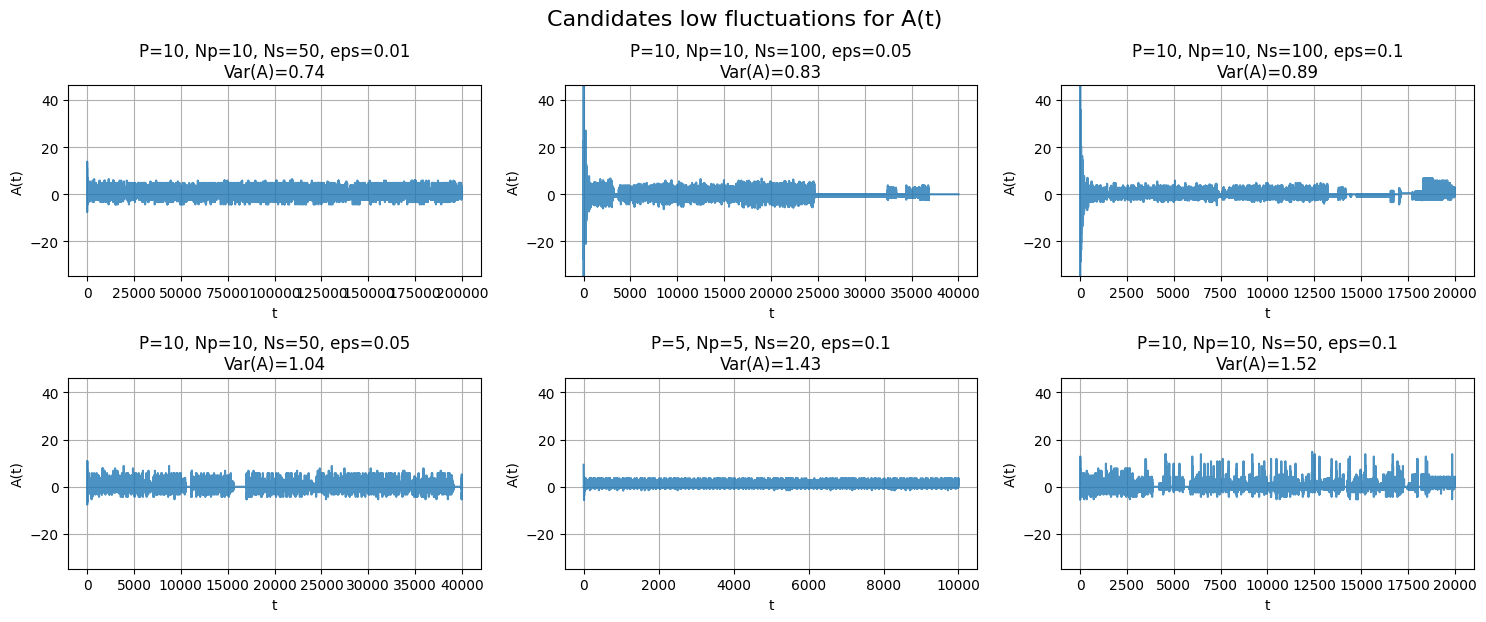

In [19]:
burnin = 25_000
iterations = burnin * 2
seed = 42
np.random.seed(seed)

# Candidate parameters
P_values = [5, 10, 20, 30, 50]
Ns_values = [20, 50, 100]
Np_values = [P for P in P_values]
eps_values = [0.01, 0.05, 0.1]

results = []

# Búsqueda
for P in tqdm(P_values):
    for Np in [P]:  # np = 1
        for Ns in Ns_values:
            for eps in eps_values:
                
                iterations = int(200 * P / eps)
                burnin = iterations // 2
                
                a, Omega, U, A, mu = create_variables(
                    seed, iterations, Ns, P, Np, init_mu_U=0.1, init_std_U=0.05)
                
                A_out, U_out = run_game(a, mu, Omega, U, A, eps, iterations)
                A_burned = A_out[burnin:]
                varA = np.var(A_burned)
                results.append((P, Np, Ns, eps, varA, A_out.copy()))


# Ordenar por menor varianza
results_sorted = sorted(results, key=lambda x: x[4])
top_candidates = results_sorted[:6]

global_min = np.min([np.min(A_out) for (_, _, _, _, _, A_out) in top_candidates])
global_max = np.max([np.max(A_out) for (_, _, _, _, _, A_out) in top_candidates])

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()

for idx, (P, Np, Ns, eps, varA, A_out) in enumerate(top_candidates):
    axes[idx].plot(A_out, alpha=0.8)
    axes[idx].set_title(f"P={P}, Np={Np}, Ns={Ns}, eps={eps}\nVar(A)={varA:.2f}")
    axes[idx].set_xlabel("t")
    axes[idx].set_ylabel("A(t)")
    axes[idx].grid(True)
    axes[idx].set_ylim(global_min, global_max)

plt.tight_layout()
plt.suptitle("Candidates low fluctuations for A(t)", fontsize=16, y=1.03)
plt.show()

from this states, we are going to choose the parameters:

```python
P = 5
Ns = 20
Np = 5
eps = 0.1
```

since they appear to be relatively stable, but also displaying some market noise, yet stationary.

### 1. Calculate the frequence activity $\phi_i$ of speculators

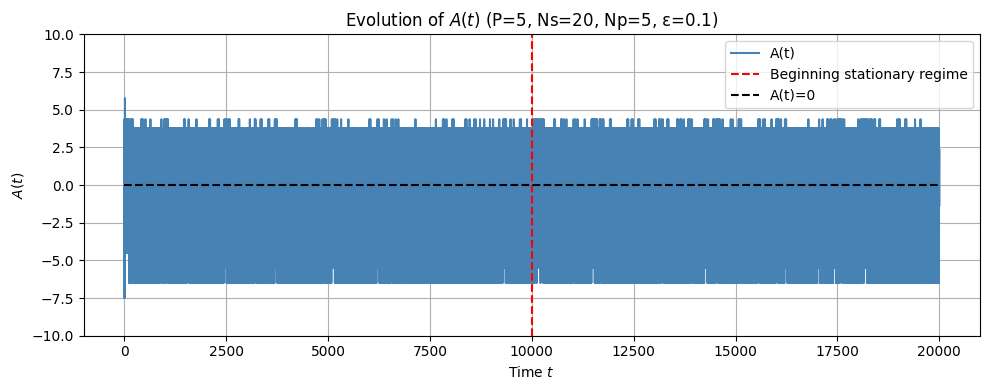

In [37]:
P = 5
Ns = 20
Np = 5
eps = 0.1
burnin = int(200 * P / eps)
iterations = burnin * 2

a, Omega, U, A, mu = create_variables(seed=12, 
                                      iterations=iterations, Ns=Ns, 
                                      P=P, Np=Np, 
                                      init_mu_U=0.1, init_std_U=0.05)
A_out, U_out, mu_hist, _, _ = run_game_gains(a, Omega, U, A, eps, mu, iterations)

# Calcular frecuencia de juego
phi = compute_phi(U_out, burnin=burnin)

plt.figure(figsize=(10, 4))
plt.plot(A_out, label="A(t)", color="steelblue")
plt.axvline(burnin, color='red', linestyle='--', label="Beginning stationary regime")
plt.hlines(0, xmin=0, xmax=iterations, color='black', linestyle='--', label="A(t)=0")
plt.xlabel("Time $t$")
plt.ylabel("$A(t)$")
plt.title(f"Evolution of $A(t)$ (P={P}, Ns={Ns}, Np={Np}, ε={eps})")
plt.legend()
plt.ylim(-10, 10)
plt.grid(True)
plt.tight_layout()
plt.show()

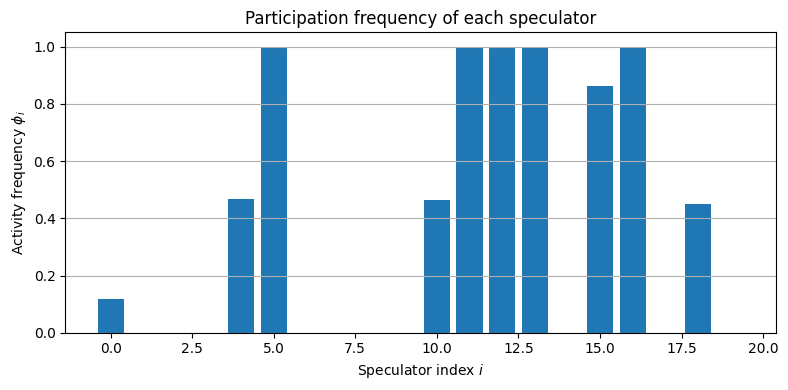

In [38]:
plt.figure(figsize=(8, 4))
plt.bar(np.arange(Ns), phi)
plt.xlabel("Speculator index $i$")
plt.ylabel("Activity frequency $\\phi_i$")
plt.title("Participation frequency of each speculator")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


### 2. Calculate the avg gain of each speculator $g_i$

By definition

$$
g_i(t) = -a_i^{\mu}(t) A(t)
$$

and the avergae gain is

$$
\bar{g}_i = \frac{1}{T} \sum_{t=0}^{T-1} g_i(t)
$$

In [39]:
a, Omega, U, A, mu = create_variables(
    seed=0, iterations=iterations, Ns=Ns, P=P, Np=Np, init_mu_U=0.1, init_std_U=0.05)

A_out, U_out, mu_hist, _, _ = run_game_gains(a, Omega, U, A, eps, mu, iterations)

phi = compute_phi(U_out, burnin)
gains = compute_individual_gains(a, A_out, mu_hist, U_out, burnin)

### 3. Trace the gain of each speculator $\bar{g_i}$ by its frequence of activity $\phi_i$

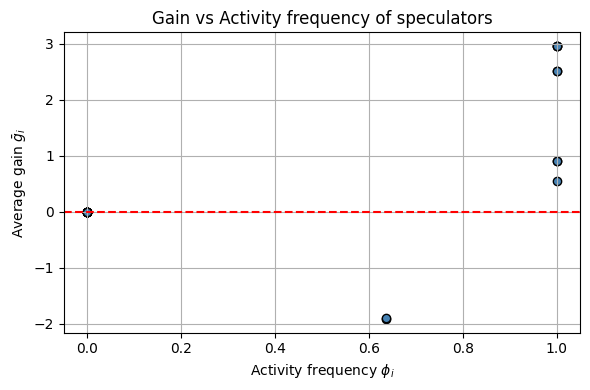

In [40]:
plt.figure(figsize=(6,4))
plt.scatter(phi, gains, c="steelblue", edgecolors="k")
plt.axhline(0, color='red', linestyle='--', label="Gain = 0")
plt.xlabel("Activity frequency $\\phi_i$")
plt.ylabel("Average gain $\\bar{g}_i$")
plt.title("Gain vs Activity frequency of speculators")
plt.grid(True)
plt.tight_layout()
plt.show()

```python
P = 5
Ns = 20
Np = 5
eps = 0.1
```

In this scenario, the ones that have a higher activity have a higher gain, this means that have better strategies, then they want to play more. The ones that are in the middle, are the ones that think that they might gain profits, but their strategies are not able to beat the strategies of the other ones (maybe they dont consider their own impact), so they end up having negative profits. Finally, there are the ones that are not active, since they don't have any good strategy.

However, in here we cannot see the dynamics very clear. If we choose parameters with more agents, we will see better the market dynamics and its interactions.

```python
P = 15
Ns = 250
Np = 15
eps = 0.01
```

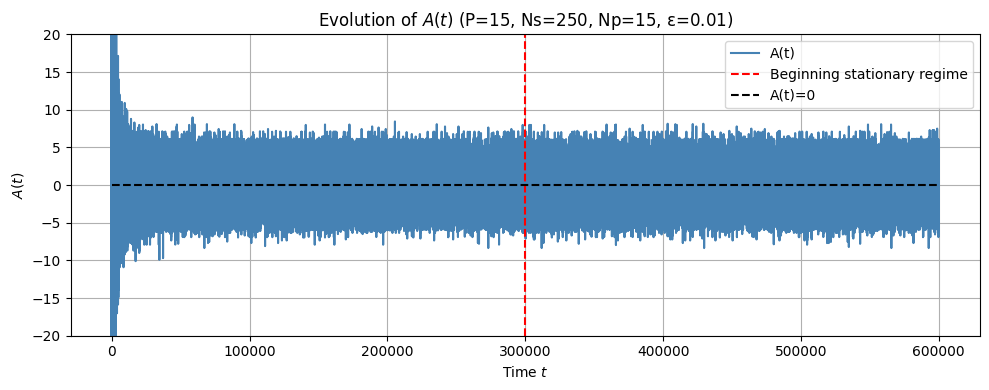

In [58]:
P = 15
Ns = 250
Np = 15
eps = 0.01
burnin = int(200 * P / eps)
iterations = burnin * 2

a, Omega, U, A, mu = create_variables(seed=12, 
                                      iterations=iterations, Ns=Ns, 
                                      P=P, Np=Np, 
                                      init_mu_U=0.1, init_std_U=0.05)
A_out, U_out, mu_hist, _, _ = run_game_gains(a, Omega, U, A, eps, mu, iterations)

# Calcular frecuencia de juego
phi = compute_phi(U_out, burnin=burnin)

plt.figure(figsize=(10, 4))
plt.plot(A_out, label="A(t)", color="steelblue")
plt.axvline(burnin, color='red', linestyle='--', label="Beginning stationary regime")
plt.hlines(0, xmin=0, xmax=iterations, color='black', linestyle='--', label="A(t)=0")
plt.xlabel("Time $t$")
plt.ylabel("$A(t)$")
plt.title(f"Evolution of $A(t)$ (P={P}, Ns={Ns}, Np={Np}, ε={eps})")
plt.legend()
plt.ylim(-20, 20)
plt.grid(True)
plt.tight_layout()
plt.show()

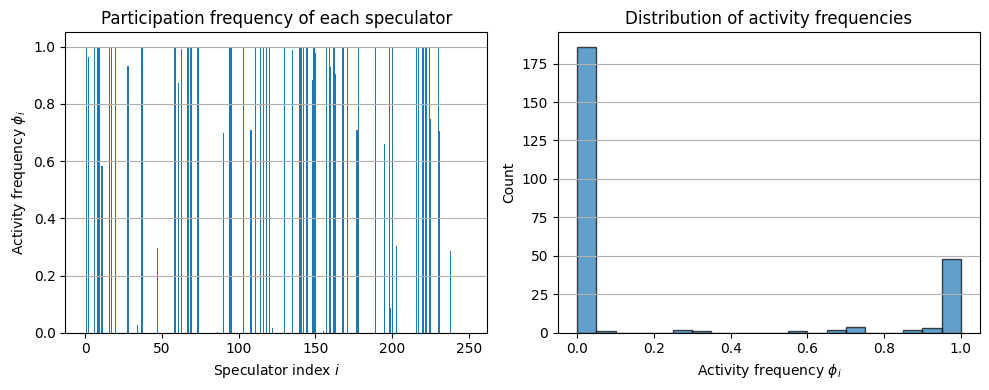

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# Left: bar plot per agent
axs[0].bar(np.arange(len(phi)), phi)
axs[0].set_xlabel("Speculator index $i$")
axs[0].set_ylabel("Activity frequency $\\phi_i$")
axs[0].set_title("Participation frequency of each speculator")
axs[0].grid(True, axis="y")

# Right: histogram of activity frequencies
axs[1].hist(phi, bins=20, range=(0, 1), edgecolor='black', alpha=0.7)
axs[1].set_xlabel("Activity frequency $\\phi_i$")
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of activity frequencies")
axs[1].grid(True, axis="y")

plt.tight_layout()
plt.show()


In [79]:
a, Omega, U, A, mu = create_variables(
    seed=0, iterations=iterations, Ns=Ns, P=P, Np=Np, init_mu_U=0.1, init_std_U=0.05)

A_out, U_out, mu_hist, _, _ = run_game_gains(a, Omega, U, A, eps, mu, iterations)

phi = compute_phi(U_out, burnin)

gains = compute_individual_gains(a, A_out, mu_hist, U_out, burnin)

C:\Users\Marti\AppData\Local\Temp\ipykernel_6604\4119977616.py:126: RuntimeWarning: invalid value encountered in divide
  gains = np.where(active_counts > 0, gain_sum / active_counts, 0)


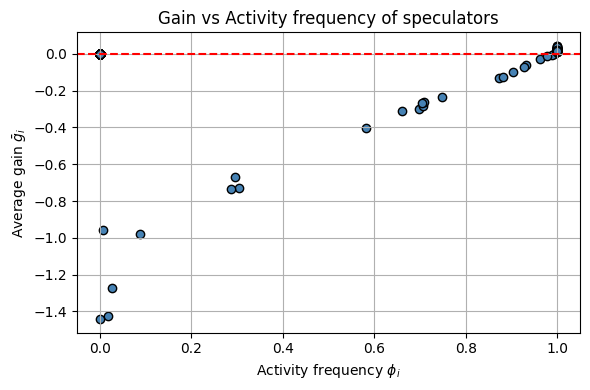

In [80]:
plt.figure(figsize=(6,4))
plt.scatter(phi, gains, c="steelblue", edgecolors="k")
plt.axhline(0, color='red', linestyle='--', label="Gain = 0")
plt.xlabel("Activity frequency $\\phi_i$")
plt.ylabel("Average gain $\\bar{g}_i$")
plt.title("Gain vs Activity frequency of speculators")
plt.grid(True)
plt.tight_layout()
plt.show()

In here we have a more diverse population behaviour. The speculators that always play have profits, but they are very small, since there are many players in the game. Then, the ones that plays ocasionally have negative gains, meaning they don't have good strategies. Finally, the ones that are not active because they dont have good strategies, so they have zero gains.

## 2 - Impact and gain

### 1. Look for parameters where the system is unstable.

In [63]:
P = 15
Np = 15
Ns = 800
eps = 0.01
iterations = int(200 * P / eps)
burnin = iterations // 2

a, Omega, U, A, mu = create_variables(seed=12, 
                                      iterations=iterations, Ns=Ns, 
                                      P=P, Np=Np, 
                                      init_mu_U=0.1, init_std_U=0.05)
A_out, U_out, mu_hist, _, _ = run_game_gains(a, Omega, U, A, eps, mu, iterations)

# Calcular frecuencia de juego
phi = compute_phi(U_out, burnin=burnin)

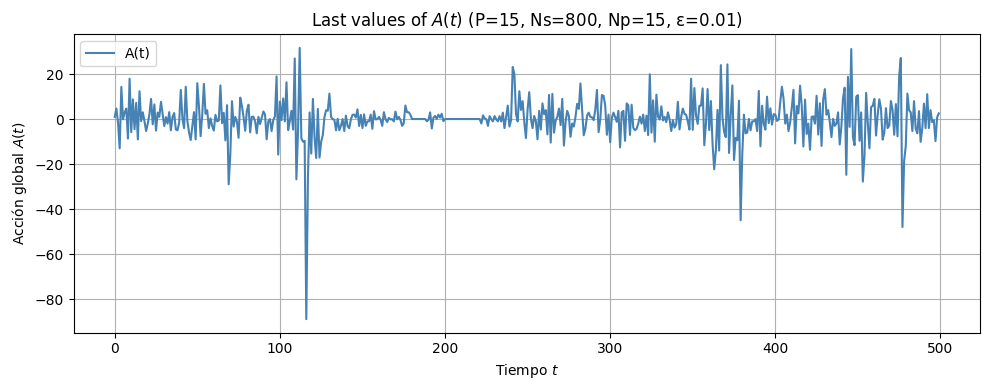

In [64]:
plt.figure(figsize=(10, 4))
plt.plot(A_out[-500:], label="A(t)", color="steelblue")
plt.xlabel("Tiempo $t$")
plt.ylabel("Acción global $A(t)$")
plt.title(f"Last values of $A(t)$ (P={P}, Ns={Ns}, Np={Np}, ε={eps})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This is a very unstable system, changing once in a while very radically.

### 2. Partial Awareness of Market Impact

Equip a fraction $ \rho $ of agents with the ability to partially take into account their own market impact, characterized by $ \kappa_i > 0 $, and whose score dynamics follow the equation:

$$
U_i(t + 1) = U_i(t) - a_{i, \mu(t)} A(t) - \epsilon - \kappa_i \times \left[1 - n_i(t)\right]
$$

Calculate the average gain of agents with $ \kappa_i > 0 $ and their activity frequency.  
Plot the average gain of each speculator as a function of their activity frequency.  

**Discuss your observations**

                 Gain  Activity
Conscious                      
False     -114.551154  0.177092
True       -46.846926  0.088692


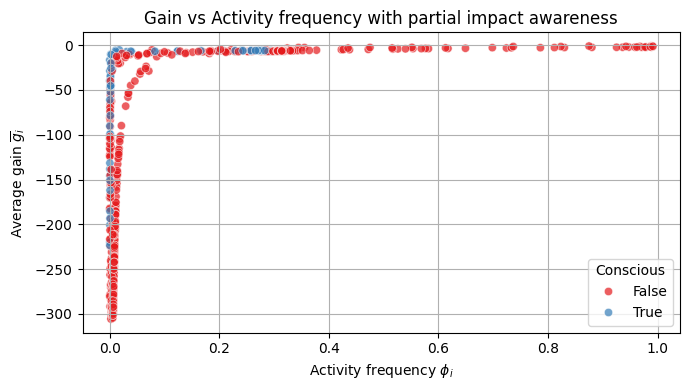

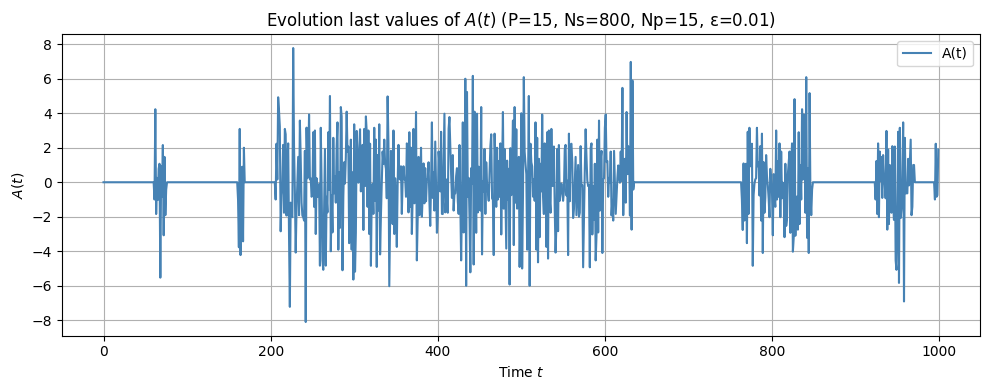

In [67]:
P = 15
Np = 15
Ns = 800
eps = 0.01

iterations = int(200 * P / 0.1)
burnin = iterations // 2

kappa_value = 0.5
rho = 0.1

a, Omega, U, A, mu = create_variables(seed=1, iterations=iterations, Ns=Ns, P=P, Np=Np, init_mu_U=0.1, init_std_U=0.05)
kappa_matrix, conscious_agents = generate_kappa_matrix(Ns, iterations, rho=rho, kappa_value=kappa_value, seed=1)

A_out, mu_hist, phi, avg_gain, kappa_matrix_out = run_game_partial_impact_matrix(a, Omega, U, A, eps, mu, iterations, kappa_matrix)

df = pd.DataFrame({
    "Gain": avg_gain,
    "Activity": phi,
    "Conscious": [i in conscious_agents for i in range(Ns)]
})

print(df.groupby("Conscious").mean())

plt.figure(figsize=(7, 4))
sns.scatterplot(data=df, x="Activity", y="Gain", hue="Conscious", palette="Set1", alpha=0.7)
plt.xlabel("Activity frequency $\\phi_i$")
plt.ylabel("Average gain $\\overline{g}_i$")
plt.title("Gain vs Activity frequency with partial impact awareness")
plt.grid(True)
#plt.yscale("log")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(A_out[-1000:], label="A(t)", color="steelblue")
#plt.axvline(burnin, color='red', linestyle='--', label="Beginning stationary regime")
#plt.hlines(0, xmin=0, xmax=iterations, color='black', linestyle='--', label="A(t)=0")
plt.xlabel("Time $t$")
plt.ylabel("$A(t)$")
plt.title(f"Evolution last values of $A(t)$ (P={P}, Ns={Ns}, Np={Np}, ε={eps})")
plt.legend()
#plt.ylim(-20, 20)
plt.grid(True)
plt.tight_layout()
plt.show()

Using the previous parameters, we are able to create an unstable market conditions after having many speculators playing.

When we add the speculators self-conscious, we can see that this group is able to beat the group unconscious in terms of average gains. They even belong to another frontier at the graph of average gain vs activity frequence. 

Another point to notice, is that the conscious players abstain from playing when they are not able to have profits, so we can see that there is no conscious agent playing 100% of the time.

Lastly, when we add this players, we see that the total volatility of $A(t)$ is reduced, which is in agreement with the theory showed on the course. This could be explained by the fact that we have less agents playing, providing less volatility to the market, or less influence of the agents to the system, and only playing when it is necessary, thus having better strategies and reducing the previsibility.